In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nivapy3 as nivapy
from scipy.stats import pearsonr
from scipy.stats import spearmanr

import matplotlib as mpl
mpl.rcParams["figure.facecolor"]
mpl.rcParams["axes.facecolor"]
mpl.rcParams["savefig.facecolor"]
# plt.style.use('ggplot')

'auto'

In [61]:
site = "Malselva"  # Malselva or Storelva

start_date_dict = {"Malselva": "2018-01-01",
                   "Storelva": "2017-01-01"}  # Tho have data from 2016

# For naming plots and files
site_name_dict = {"Malselva": "Målselva",
                  "Storelva": "Storelva"}

# Read in data

## Read in sensor data

In [62]:
fpath = r'../data/sensor_%s.csv' % site

sensor_df_hourly = pd.read_csv(fpath, index_col=1, parse_dates=True, na_values="NA")
sensor_df_hourly = sensor_df_hourly.drop('station_name', axis=1)
sensor_df_hourly.columns = ["FDOM", "Conductivity", "pH", "T_water", "Turbidity"]
sensor_df_hourly.dropna(how="all", axis=0, inplace=True)

# Remove UTC timezone info. N.B. need to double-check this was always 0
# In future, also need to double-check summer time vs winter time for both sensors
# and grab samples
sensor_df_hourly.index = sensor_df_hourly.index.tz_localize(None)

sensor_df_hourly

,FDOM,Conductivity,pH,T_water,Turbidity
datetime,,,,,
2018-01-01 00:00:00,11.14,4.942,7.459,0.004,NaN
2018-01-01 01:00:00,10.89,4.940,7.453,0.010,NaN
2018-01-01 02:00:00,10.94,4.924,7.437,0.008,NaN
2018-01-01 03:00:00,11.04,4.904,7.459,0.003,NaN
2018-01-01 04:00:00,10.94,4.876,7.462,0.007,NaN
...,...,...,...,...,...
2021-12-30 20:00:00,NaN,NaN,7.290,0.158,2.05
2021-12-30 21:00:00,NaN,NaN,7.281,0.159,2.06
2021-12-30 22:00:00,NaN,NaN,7.267,0.162,2.06


In [63]:
# Round sensor data timestamp to the nearest hour, for joining with Q and grab sample data
sensor_df_hourly.index = sensor_df_hourly.index.round(freq='H')
sensor_df_hourly.sort_index(inplace=True)  # Not sure it was sorted; do in case
sensor_df_hourly.head(2)

,FDOM,Conductivity,pH,T_water,Turbidity
datetime,,,,,
2018-01-01 00:00:00,11.14,4.942,7.459,0.004,NaN
2018-01-01 01:00:00,10.89,4.940,7.453,0.010,NaN


In [64]:
# Resample to daily

sensor_df = sensor_df_hourly.resample('D').mean()
# Drop time info for joining and plotting
sensor_df.index = sensor_df.index.date
sensor_df

,FDOM,Conductivity,pH,T_water,Turbidity
2018-01-01,11.065417,4.930958,7.453875,0.005750,NaN
2018-01-02,10.982500,5.267292,7.446125,0.006167,NaN
2018-01-03,10.800000,5.097292,7.432292,0.005625,NaN
2018-01-04,10.571667,5.219750,7.435583,0.004958,NaN
2018-01-05,10.526667,4.797000,7.442167,0.004083,NaN
...,...,...,...,...,...
2021-12-27,NaN,NaN,7.320083,0.156750,2.562500
2021-12-28,NaN,NaN,7.313333,0.158042,2.428750
2021-12-29,NaN,NaN,7.314125,0.157542,2.194167
2021-12-30,NaN,NaN,7.290125,0.156042,2.099583


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

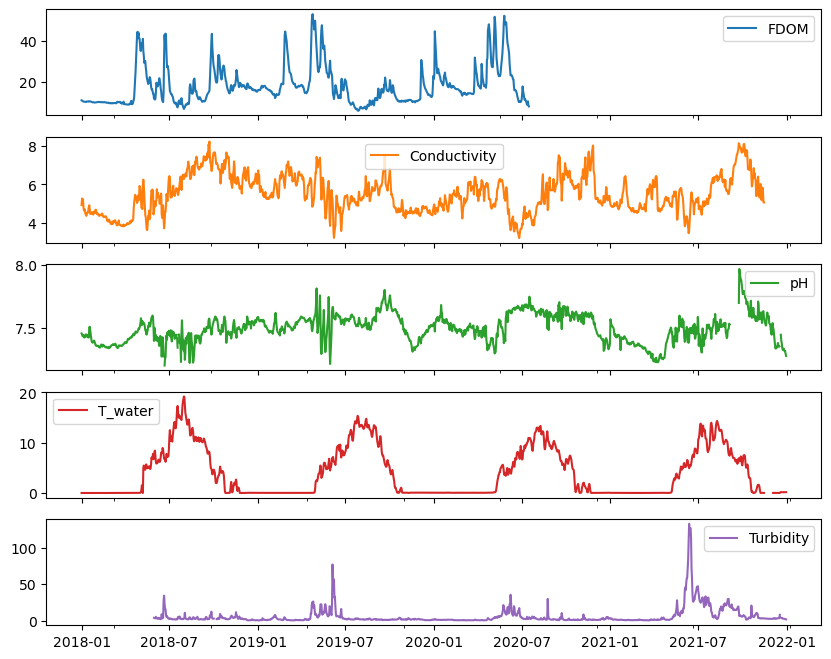

In [65]:
sensor_df.plot(subplots=True, sharex=True, figsize=(10, 8))

## Read in met data

In [66]:
met_fpath = r"../data/Climate_%s_daily.csv" % site
met_df = pd.read_csv(met_fpath, index_col=0, parse_dates=True, dayfirst=False)
met_df = met_df[['par', 'value_mean']]
met_df = met_df.pivot(columns='par')
met_df = met_df.droplevel(level=0, axis=1)
met_df.columns = ['Pptn', 'T_air']
met_df.index = met_df.index.date  # Drop time info
met_df

,Pptn,T_air
2017-01-01,2.9,-6.7
2017-01-02,3.1,-8.6
2017-01-03,0.2,-16.1
2017-01-04,0.0,-18.2
2017-01-05,0.1,-23.7
...,...,...
2021-12-27,0.3,-14.1
2021-12-28,0.4,-13.7
2021-12-29,0.1,-16.8
2021-12-30,0.9,-15.9


## Read in discharge data

In [67]:
q_hrly_fpath_dict = {'Malselva': r'../../data/discharge/Q_målselvfossen_alldata_hourly-resolution_downloaded-2022-11.csv',
                     'Storelva': r'../data/Discharge_Storelva_18-4-0_hourly.csv'}

q_hourly_df = pd.read_csv(q_hrly_fpath_dict[site], index_col=0, parse_dates=True)
q_hourly_df.columns = ['Q', 'Korrigert', 'Kontrollert']
q_hourly_df = q_hourly_df['Q']
q_hourly_df.index.name = 'datetime'

# Remove UTC timezone info. N.B. need to double-check this was always 0
# In future, also need to double-check summer time vs winter time for both sensors
# and grab samples
q_hourly_df.index = q_hourly_df.index.tz_localize(None)

q_hourly_df.head()

datetime
1965-04-23 20:00:00    25.10577
1965-04-23 21:00:00    25.19177
1965-04-23 22:00:00    25.23794
1965-04-23 23:00:00    25.28324
1965-04-24 00:00:00    25.32657
Name: Q, dtype: float64

In [68]:
q_df = pd.read_csv(r'../data/Discharge_%s.csv' % site, index_col=0, parse_dates=True)

# Drop time info for joining and plotting
q_df.index = q_df.index.date

q_series = q_df['value']
q_series.name = 'Q'
q_series

2015-01-01    56.558560
2015-01-02    53.745498
2015-01-03    52.647726
2015-01-04    51.549936
2015-01-05    50.457881
                ...    
2021-12-26    64.969258
2021-12-27    59.625203
2021-12-28    60.027650
2021-12-29    56.059210
2021-12-30    50.387464
Name: Q, Length: 2556, dtype: float64

**Maeve's Q data is missing the last day of the series. Doesn't matter for now, but in future re-do with raw NVE data**

## Read in grab sample water chem data

In [69]:
chem_df_hrly = pd.read_csv(r'../data/waterchem_%s.csv' % site, index_col=1, parse_dates=True)
chem_df_hrly.drop(chem_df_hrly.columns[0], axis=1, inplace=True)
# Drop rows where there were no samples at all
chem_df_hrly.dropna(axis=0, how="all", inplace=True)

chem_df_hrly.index = chem_df_hrly.index.round(freq='H')
chem_df_hrly.sort_index(inplace=True)  # Not sure it was sorted; do in case

# Remove UTC timezone info. N.B. need to double-check this was always 0
# In future, also need to double-check summer time vs winter time for both sensors
# and grab samples
chem_df_hrly.index = chem_df_hrly.index.tz_localize(None)

chem_df_hrly.tail()

,pH,Conductivity_mS_m,SPM_mg_L,TOC_mgC_L,Turbiditet_NTU,PO4_ug_L,TP_ug_L,NO3_ug_L,NH4_ug_L,TN_ug_L,Si_mg_L,Ca_mg_L,DOC_mg_L,PartC_ug_L,PartN_ug_L,TDP_ug_L,sampling
datetime,,,,,,,,,,,,,,,,,
2021-08-02 10:00:00,7.53,7.51,1.05,0.77,0.64,NaN,2.0,23.0,NaN,71.0,0.914,8.43,0.78,150.0,13.00,NaN,monthly
2021-09-06 13:00:00,7.70,7.29,0.88,1.10,0.61,1.0,4.0,19.0,3.0,60.0,1.010,10.80,1.10,276.0,14.50,NaN,monthly
2021-10-04 12:00:00,7.79,9.62,4.73,0.80,0.78,2.0,3.0,42.0,2.0,87.0,1.140,12.90,0.78,251.0,29.20,NaN,monthly
2021-11-01 12:00:00,7.65,7.65,1.52,1.00,0.40,1.0,3.0,44.0,4.0,580.0,1.260,10.20,1.10,129.0,21.40,NaN,monthly
2021-12-06 10:00:00,7.76,8.65,0.22,0.82,NaN,NaN,1.0,57.0,5.0,110.0,1.390,11.70,0.79,59.2,6.08,NaN,monthly


In [70]:
# Drop time info for joining and plotting with daily data
chem_df = chem_df_hrly.copy()
chem_df.index = chem_df_hrly.index.date

# Add column for joining with rest of data, simple boolean saying there was a sample this date
chem_df['grab_sample'] = True

chem_df.tail()

,pH,Conductivity_mS_m,SPM_mg_L,TOC_mgC_L,Turbiditet_NTU,PO4_ug_L,TP_ug_L,NO3_ug_L,NH4_ug_L,TN_ug_L,Si_mg_L,Ca_mg_L,DOC_mg_L,PartC_ug_L,PartN_ug_L,TDP_ug_L,sampling,grab_sample
2021-08-02,7.53,7.51,1.05,0.77,0.64,NaN,2.0,23.0,NaN,71.0,0.914,8.43,0.78,150.0,13.00,NaN,monthly,True
2021-09-06,7.70,7.29,0.88,1.10,0.61,1.0,4.0,19.0,3.0,60.0,1.010,10.80,1.10,276.0,14.50,NaN,monthly,True
2021-10-04,7.79,9.62,4.73,0.80,0.78,2.0,3.0,42.0,2.0,87.0,1.140,12.90,0.78,251.0,29.20,NaN,monthly,True
2021-11-01,7.65,7.65,1.52,1.00,0.40,1.0,3.0,44.0,4.0,580.0,1.260,10.20,1.10,129.0,21.40,NaN,monthly,True
2021-12-06,7.76,8.65,0.22,0.82,NaN,NaN,1.0,57.0,5.0,110.0,1.390,11.70,0.79,59.2,6.08,NaN,monthly,True


# Join and plot data

## Daily: All but grab samples

In [71]:
df_li = [met_df, q_series, sensor_df, chem_df['grab_sample']]
df = pd.concat(df_li, axis=1, sort=True)

# Fill in 0s for days when there weren't grab samples
df.loc[df['grab_sample'] != 1, 'grab_sample'] = False

index = pd.to_datetime(df.index, yearfirst=True)
df.index = index

# Truncate to start on 01/01/2017
start_date = start_date_dict[site]
df = df.loc[start_date:]

df

,Pptn,T_air,Q,FDOM,Conductivity,pH,T_water,Turbidity,grab_sample
2018-01-01,0.7,-9.2,41.101182,11.065417,4.930958,7.453875,0.005750,NaN,False
2018-01-02,0.2,-9.1,42.034923,10.982500,5.267292,7.446125,0.006167,NaN,False
2018-01-03,1.0,-9.2,41.365864,10.800000,5.097292,7.432292,0.005625,NaN,False
2018-01-04,3.7,-8.7,40.876937,10.571667,5.219750,7.435583,0.004958,NaN,False
2018-01-05,0.3,-13.0,41.091991,10.526667,4.797000,7.442167,0.004083,NaN,False
...,...,...,...,...,...,...,...,...,...
2021-12-27,0.3,-14.1,59.625203,NaN,NaN,7.320083,0.156750,2.562500,False
2021-12-28,0.4,-13.7,60.027650,NaN,NaN,7.313333,0.158042,2.428750,False
2021-12-29,0.1,-16.8,56.059210,NaN,NaN,7.314125,0.157542,2.194167,False
2021-12-30,0.9,-15.9,50.387464,NaN,NaN,7.290125,0.156042,2.099583,False


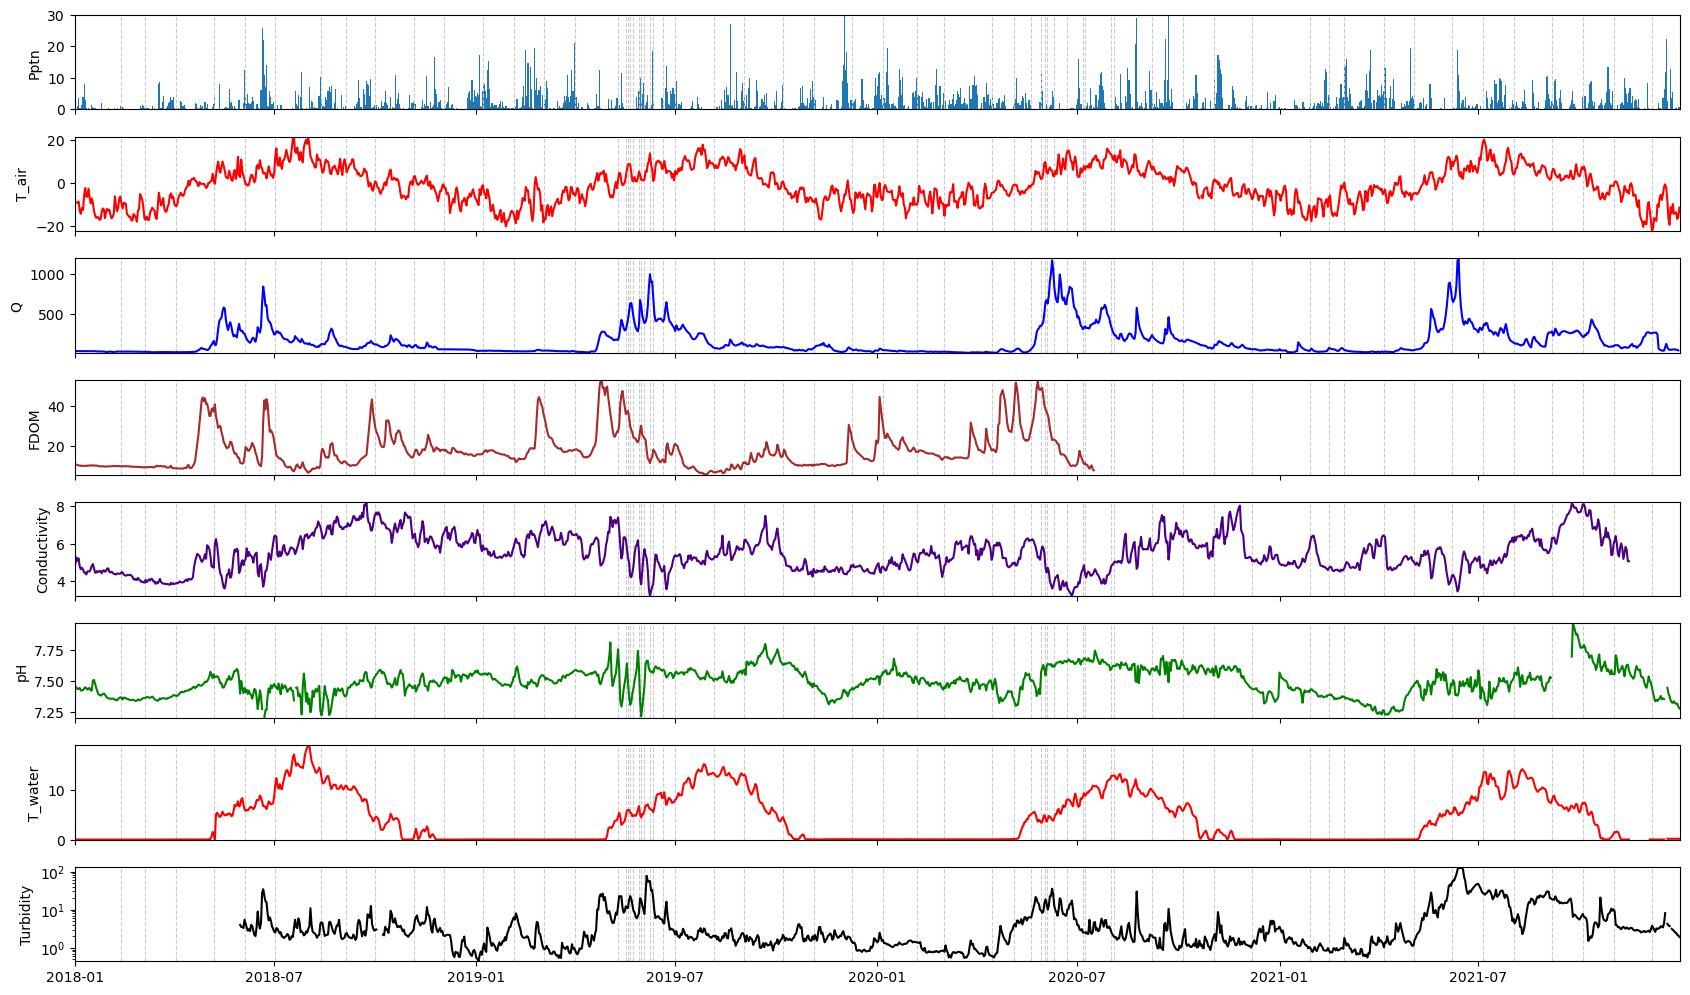

In [72]:
# Get sampling dates for plotting below
samp_dates = df.loc[df['grab_sample'] == True].index.values

colours = ['blue', 'red', 'blue', 'brown', 'indigo', 'green', 'red', 'black']

fig, axs = plt.subplots(len(df.columns)-1, 1, sharex=True, figsize=(17, 10))

for i, var in enumerate(df.columns[:-1]):
    # Plot sampling dates as vertical lines
    for date in samp_dates:
        axs[i].axvline(date, color='0.8', linestyle='--', linewidth=0.8)

    if var == 'Pptn':
        axs[i].bar(df.index, df[var], width=1)
    else:
        axs[i].plot(df.index, df[var], marker='', color=colours[i])

    axs[i].set_ylabel(df.columns[i])
    if var == 'Turbidity':
        axs[i].set_yscale("log")

    # Sort out xaxis limits (the buffer was too big by default)
    axs[i].margins(0.0)

# plt.suptitle("%s" % site_name_dict[site], size=12);
plt.tight_layout()
plt.savefig(r'../figures/timeseries_all-data_%s.png' % site, dpi=150)

array([<AxesSubplot:title={'center':'Q'}>,
       <AxesSubplot:title={'center':'Pptn'}>,
       <AxesSubplot:title={'center':'T_air'}>], dtype=object)

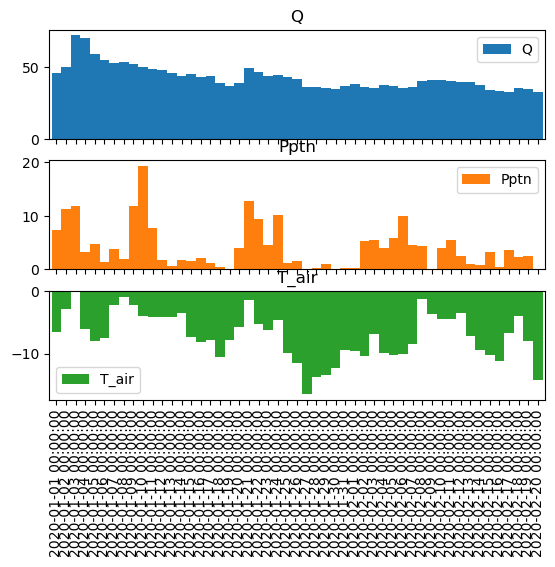

In [73]:
df.loc['2020-01-01':'2020-02-20', ['Q', 'Pptn', 'T_air']].plot(subplots=True, kind='bar', width=1)

## Hourly discharge and sensor data

In [74]:
df_li = [sensor_df_hourly, q_hourly_df]
df_hourly = pd.concat(df_li, axis=1, sort=True)

# index = pd.to_datetime(df.index, yearfirst=True)
# df.index = index

# Truncate to start on 01/01/2017
start_date = start_date_dict[site]
df = df.loc[start_date:]

# Quick check it's working; select a period when all should have data
df_hourly.loc['2020-01-01':].head()

,FDOM,Conductivity,pH,T_water,Turbidity,Q
datetime,,,,,,
2020-01-01 00:00:00,22.76,4.990,7.542,0.055,1.46,25.61895
2020-01-01 01:00:00,22.95,5.000,7.537,0.061,1.47,25.55921
2020-01-01 02:00:00,22.86,4.994,7.535,0.073,1.53,25.54430
2020-01-01 03:00:00,22.81,4.982,7.527,0.065,1.51,25.48466
2020-01-01 04:00:00,22.86,4.976,7.539,0.057,1.34,25.38050


## Add season info to both

**Define 3 or 4 seasons a year. Also whether or not it's freshet**

Spring freshet dates according to FLLINK snow coverage data for the full 0-2500m band at 20% threshold:

* 2018: Starts mid-April. Snow gone by end of June, and all the snow that was gonna melt that year gone by around June 8th
* 2019: Start mid-April. Snow gone by end of July, but 
* 2020: Start at start of April. Snow gone by start of August.

For now, we have decided to just classify freshet as May-June

In [75]:
# Define 3 seasons per year.
if site == 'Malselva':
    def season(x):
        """Input month number, and return the season it corresponds to
        """
        if x in [5, 6]:
            return 'spring'
        if x in [7, 8]:
            return 'summer'
        else:
            return 'winter'

    def freshet(x):
        """Input month number, return whether freshet or not"""
        if x in [5, 6]:
            return 'Freshet'
        else:
            return 'Not freshet'

elif site == 'Storelva':
    def season(x):
        """Input month number, and return the season it corresponds to
        """
        if x in [3, 4, 5]:
            return 'spring'
        if x in [6, 7, 8]:
            return 'summer'
        if x in [9, 10, 11]:
            return 'autumn'
        else:
            return 'winter'

df_hourly["Season"] = df_hourly.index.month.map(season)
df_hourly.loc[['2020-03-31', '2020-04-01', '2020-06-30', '2020-07-01', '2020-09-30', '2020-10-01']]

,FDOM,Conductivity,pH,T_water,Turbidity,Q,Season
datetime,,,,,,,
2020-03-31,21.59,5.410,7.544,0.052,0.95,14.13098,winter
2020-04-01,20.66,5.579,7.508,0.039,0.70,14.73579,winter
2020-06-30,10.50,3.731,7.630,9.440,4.80,305.46030,spring
2020-07-01,11.23,3.683,7.673,7.606,7.22,271.50480,summer
2020-09-30,NaN,6.890,7.580,5.978,0.79,NaN,winter
2020-10-01,NaN,7.097,7.611,6.528,0.85,NaN,winter


In [76]:
df["Season"] = df.index.month.map(season)
df.loc[['2020-03-31', '2020-04-01', '2020-06-30', '2020-07-01', '2020-09-30', '2020-10-01']]

/tmp/ipykernel_122/1472096899.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Season"] = df.index.month.map(season)


,Pptn,T_air,Q,FDOM,Conductivity,pH,T_water,Turbidity,grab_sample,Season
2020-03-31,7.8,-8.2,26.544092,21.155417,5.387417,7.511625,0.045250,0.858750,False,winter
2020-04-01,4.5,-5.6,27.168339,19.838750,5.643750,7.492542,0.039625,0.804167,False,winter
2020-06-30,1.5,9.3,544.958179,10.736250,3.689625,7.648333,8.627583,5.360833,False,spring
2020-07-01,3.2,3.6,460.281952,11.529167,3.730875,7.652708,7.276750,3.917500,False,summer
2020-09-30,0.0,8.0,188.520263,NaN,6.787792,7.596458,6.251875,0.883333,False,winter
2020-10-01,0.0,7.2,177.787746,NaN,6.827292,7.608167,6.738458,0.863478,False,winter


## Join grab samples for regression

### Join daily data
(chem_reg_df, spm_reg_df)
Future improvement: just call reg_df, and have a dictionary with variable name

In [77]:
# For DOC
s_li = [sensor_df['FDOM'], chem_df['DOC_mg_L']]
chem_reg_df = pd.concat(s_li, axis=1, join='inner', sort=True)
chem_reg_df.columns = ['FDOM', 'DOC']
index = pd.to_datetime(chem_reg_df.index, yearfirst=True)
chem_reg_df.index = index
chem_reg_df["Season"] = chem_reg_df.index.month.map(season)
if site == 'Malselva':
    chem_reg_df['Freshet'] = chem_reg_df.index.month.map(freshet)
chem_reg_df.dropna(how='any', inplace=True)
chem_reg_df.to_csv(r'../data/fdom_doc_%s.csv' % site)
chem_reg_df.head()

,FDOM,DOC,Season,Freshet
2018-02-12,10.143750,0.90,winter,Not freshet
2018-03-05,9.657500,1.10,winter,Not freshet
2018-04-03,9.120417,0.98,winter,Not freshet
2018-05-07,37.276667,3.50,spring,Freshet
2018-06-04,14.960833,1.00,spring,Freshet


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

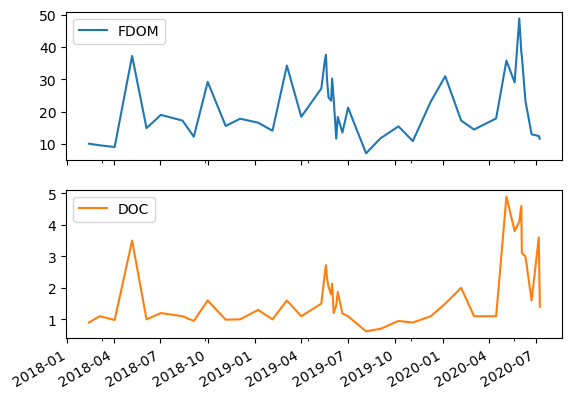

In [78]:
chem_reg_df.plot(subplots=True)

**QC**
* **The 2020 Målselva DOC data are suspiciously high. Decide to drop them for now**
* There's one point in the Målselva grab sample DOC data that I don't believe. Over 2 days there's a huge change in DOC, which isn't seen in FDOM, and there's not much change in Q either. It's a real outlier on the FDOM:DOC plot. So decide to delete that point.

In [79]:
if site == 'Malselva':
    chem_reg_df.loc['2020-07-06', 'DOC'] = np.NaN
    chem_reg_df.dropna(how='any', inplace=True)
    chem_reg_df = chem_reg_df.loc[:'2020-02-01']

In [80]:
# For SPM
s_li = [sensor_df['Turbidity'], chem_df['SPM_mg_L']]
spm_reg_df = pd.concat(s_li, axis=1, join='inner', sort=True)
spm_reg_df.columns = ['Turbidity', 'SPM']
index = pd.to_datetime(spm_reg_df.index, yearfirst=True)
spm_reg_df.index = index
spm_reg_df.dropna(how='any', inplace=True)

if site == 'Malselva':
    spm_reg_df['Freshet'] = spm_reg_df.index.month.map(freshet)

spm_reg_df.to_csv(r'../data/spm_turbidity_for_regression%s.csv' % site)
spm_reg_df.head()

,Turbidity,SPM,Freshet
2018-06-04,5.445417,5.83,Freshet
2018-07-02,2.501667,1.63,Not freshet
2018-08-13,4.683750,3.74,Not freshet
2018-09-04,2.303750,0.86,Not freshet
2018-10-01,2.977647,0.77,Not freshet


### Join hourly data

In [81]:
# For SPM
s_li = [sensor_df_hourly['Turbidity'], chem_df_hrly['SPM_mg_L']]
spm_reg_df_hourly = pd.concat(s_li, axis=1, join='inner', sort=True)
spm_reg_df_hourly.columns = ['Turbidity', 'SPM']
index = pd.to_datetime(spm_reg_df_hourly.index, yearfirst=True)
spm_reg_df_hourly.index = index
spm_reg_df_hourly.dropna(how='any', inplace=True)

if site == 'Malselva':
    spm_reg_df_hourly['Freshet'] = spm_reg_df_hourly.index.month.map(freshet)

spm_reg_df_hourly.to_csv(r'../data/spm_turbidity_for_regression_%s_hourly-join.csv' % site)
spm_reg_df_hourly.head()

,Turbidity,SPM,Freshet
datetime,,,
2018-06-04 00:00:00,3.49,5.83,Freshet
2018-07-02 15:00:00,2.33,1.63,Not freshet
2018-08-13 10:00:00,4.89,3.74,Not freshet
2018-09-04 13:00:00,1.16,0.86,Not freshet
2018-10-01 12:00:00,4.31,0.77,Not freshet


In [82]:
# For FDOM
s_li = [sensor_df_hourly['FDOM'], chem_df_hrly['DOC_mg_L']]
fdom_reg_df_hourly = pd.concat(s_li, axis=1, join='inner', sort=True)
fdom_reg_df_hourly.columns = ['FDOM', 'DOC']
index = pd.to_datetime(fdom_reg_df_hourly.index, yearfirst=True)
fdom_reg_df_hourly.index = index
fdom_reg_df_hourly["Season"] = fdom_reg_df_hourly.index.month.map(season)
if site == 'Malselva':
    fdom_reg_df_hourly['Freshet'] = fdom_reg_df_hourly.index.month.map(freshet)
fdom_reg_df_hourly.dropna(how='any', inplace=True)
fdom_reg_df_hourly.to_csv(r'../data/doc_fdom_for_regression_%s_hourly-join.csv' % site)
fdom_reg_df_hourly.head()

,FDOM,DOC,Season,Freshet
datetime,,,,
2018-02-12 14:00:00,10.06,0.90,winter,Not freshet
2018-03-05 14:00:00,9.57,1.10,winter,Not freshet
2018-04-03 16:00:00,9.08,0.98,winter,Not freshet
2018-05-07 10:00:00,38.68,3.50,spring,Freshet
2018-06-04 00:00:00,11.72,1.00,spring,Freshet


# Basic exploratory plots

## Boxplots of sensor and grab sample data

To do.

# QC relationships and plots

## Time series

**Ideas for periods to zoom in on:**

**Storelva:**
* Dec2020-Jan2021: example of an acidification episode, i.e. a short-lived drop in pH due to e.g. snowmelt, heavy rainfall and/or seasalt deposition. Sensors detect these acid episodes. The biological response to these episodes depends on the increase in H+ and Al, as well as the timing and duration. Kroglund et al. (2008) showed that at after just 24 hours of exposure smolt mortality was high at pH<5.5, given sufficient Al in the system. https://hess.copernicus.org/articles/12/491/2008/hess-12-491-2008.pdf. **BUT:** when plot hourly data, see that water temp during this "event" increases above 20 degrees and there are data gaps in T and FDOM. Suspicious. Don't believe it.

* August to October 2018: dry summer followed by large rainfall event, with associated sharp peaks/drops. Plot: Q, FDOM, pH, turb.

**Målselva:**
* 2019 freshet, when FDOM rises really high as Q rises a little, then see much smaller increase in subsequent discharge peaks (i.e. first flushing effect, or near-river sources)

<Figure size 640x480 with 0 Axes>

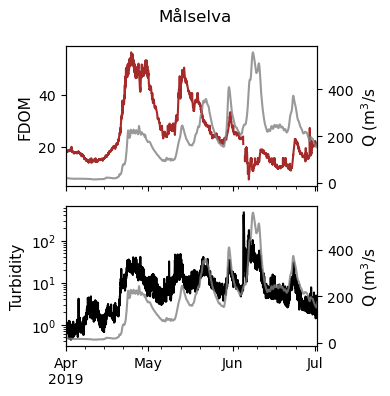

In [83]:
zoom_periods_dict = {'Storelva': ['2018-09-05', '2018-09-15',
                                  ['FDOM', 'Turbidity']],
                     'Malselva': ['2019-04-01', '2019-07-01',
                                  ['FDOM', 'Turbidity']]
                    }

figsize_dict = {'Storelva': (4, 4),
                'Malselva': (4, 4)}

li = zoom_periods_dict[site]

zoom_df = df_hourly.loc[li[0]: li[1], li[2]+['Q']]

# Time series plot
fig = plt.figure()
axs = zoom_df[li[2]].plot(subplots=True, legend=False,
                          style=['brown', 'black'], figsize=figsize_dict[site]);

for i, ax in enumerate(axs):
    ax2 = zoom_df['Q'].plot(secondary_y=True, color='grey', ax=axs[i],
                            mark_right=False, alpha=0.8)
    var = zoom_df.columns[i]

    if var == 'Turbidity':
        axs[i].set_yscale("log")

    axs[i].set_ylabel(zoom_df.columns[i], size=11)
    ax2.set_ylabel('Q (m$^3$/s', size=11)
    axs[i].set_xlabel('')
    axs[i].tick_params(axis='x', labelsize=10)

plt.suptitle("%s" % site_name_dict[site], size=12);

plt.tight_layout()
plt.savefig(r'../figures/timeseries_event-example_%s.png' % site)

In [84]:
# zoom_df.to_csv('../data/%s_%s_to_%s.csv' %(site, li[0], li[1]))

## QC relationships

### Just the chosen events

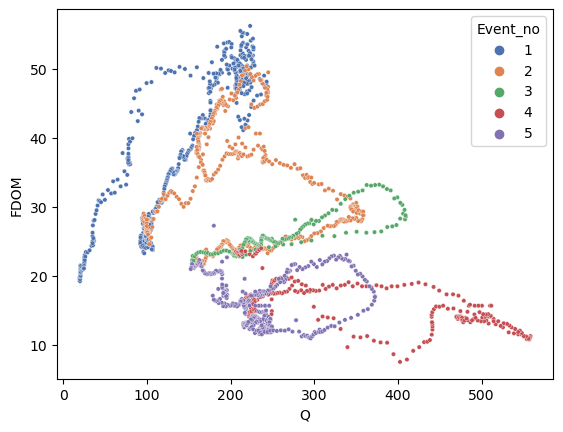

In [85]:
if site == "Malselva":
    event_df = pd.read_csv('../data/%s_%s_to_%s.csv' % (site, li[0], li[1]), index_col=0, parse_dates=True)
    sns.scatterplot(x="Q", y="FDOM", data=event_df, hue="Event_no", palette="deep", s=10)
    plt.savefig(r'../figures/FDOM-Q_2019freshet_%s_coloured-by-event-no.png' % site)

Text(0.5, 0, 'Q')

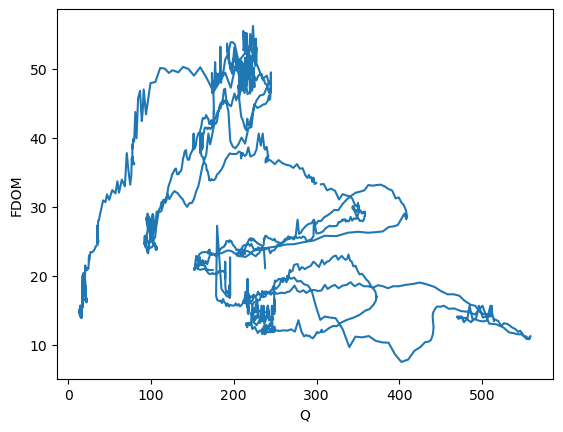

In [86]:
# QC plot (just FDOM)
ax = plt.plot(zoom_df['Q'], zoom_df['FDOM'], marker='', ms=2, linestyle='-')
plt.ylabel('FDOM')
plt.xlabel('Q')
# plt.xscale('log')

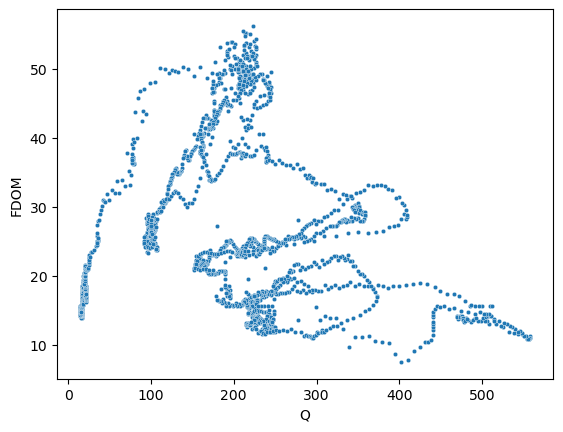

In [87]:
sns.scatterplot(x="Q", y="FDOM", data=zoom_df, s=10)
plt.savefig(r'../figures/FDOM-Q_event_%s.png' % site)

N.B. this R package looks like it could be useful: https://cran.r-project.org/web/packages/hysteresis/vignettes/index.html. Or there's also this python one: https://pypi.org/project/hysteresis/

### Whole period

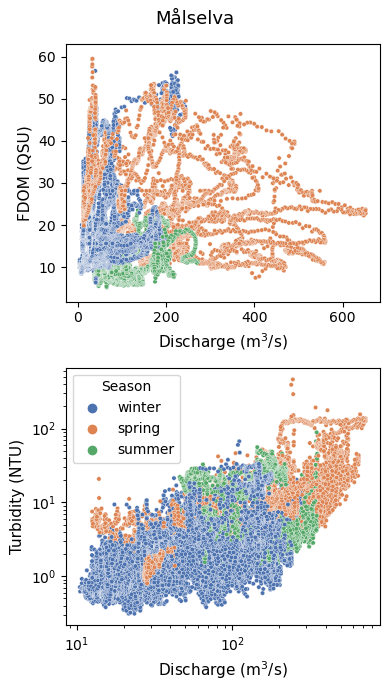

In [88]:
var_li = ["FDOM", "Turbidity"]
if site == 'Malselva':
    hue_order = ['winter', 'spring', 'summer']
else:
    hue_order = ['winter', 'spring', 'summer', 'autumn']

fig, axs = plt.subplots(2, 1, figsize=(4, 7))
for i, var in enumerate(var_li):
    # Hourly data
    sns.scatterplot(x="Q", y=var, data=df_hourly, s=10, hue="Season",
                    palette="deep",
                    hue_order=hue_order,
                    ax=axs[i])

    if site == 'Malselva' and var == 'FDOM':
        axs[i].set_ylim(ymax=63)

    if var == 'Turbidity':
        # axs[i].set_ylim(ymin=0)
        axs[i].set_yscale('log')
        axs[i].set_xscale('log')

    axs[i].set_xlabel('Discharge (m$^3$/s)', size=11)
    if var == 'FDOM':
        axs[i].set_ylabel('FDOM (QSU)', size=11)
    else:
        axs[i].set_ylabel('Turbidity (NTU)', size=11)

    if i==0:
        axs[i].get_legend().remove()

plt.suptitle("%s" % site_name_dict[site], size=13);
plt.tight_layout()
plt.savefig(r'../figures/CQ_hourly_AllData_%s.png' % (site))

In [89]:
df_hourly.corr(method='spearman')

,FDOM,Conductivity,pH,T_water,Turbidity,Q
FDOM,1.000000,0.319746,0.163338,-0.057187,0.154540,0.223461
Conductivity,0.319746,1.000000,0.275296,0.213194,-0.079890,0.085200
pH,0.163338,0.275296,1.000000,0.375165,0.028944,0.413632
T_water,-0.057187,0.213194,0.375165,1.000000,0.459294,0.700892
Turbidity,0.154540,-0.079890,0.028944,0.459294,1.000000,0.649456
Q,0.223461,0.085200,0.413632,0.700892,0.649456,1.000000


In [90]:
# def calculate_pvalues(df):
#     dfcols = pd.DataFrame(columns=df.columns)
#     pvalues = dfcols.transpose().join(dfcols, how='outer')
#     for r in df.columns:
#         for c in df.columns:
#             tmp = df[df[r].notnull() & df[c].notnull()]
#             pvalues[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)
#     return pvalues

# calculate_pvalues(df_hourly)
tmp = df_hourly[['FDOM', 'Q']].copy().dropna(axis=0)
print(spearmanr(tmp['FDOM'], tmp['Q']))

tmp = df_hourly[['Turbidity', 'Q']].copy().dropna(axis=0)
print(spearmanr(tmp['Turbidity'], tmp['Q']))

SpearmanrResult(correlation=0.2234613334163386, pvalue=4.3811502168387307e-249)
SpearmanrResult(correlation=0.6494556467823754, pvalue=0.0)


Regression results for the model with the lowest AIC:

                            OLS Regression Results                            
Dep. Variable:                   FDOM   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     883.9
Date:                Thu, 10 Nov 2022   Prob (F-statistic):          1.66e-190
Time:                        09:58:10   Log-Likelihood:                -80882.
No. Observations:               22184   AIC:                         1.618e+05
Df Residuals:                   22182   BIC:                         1.618e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

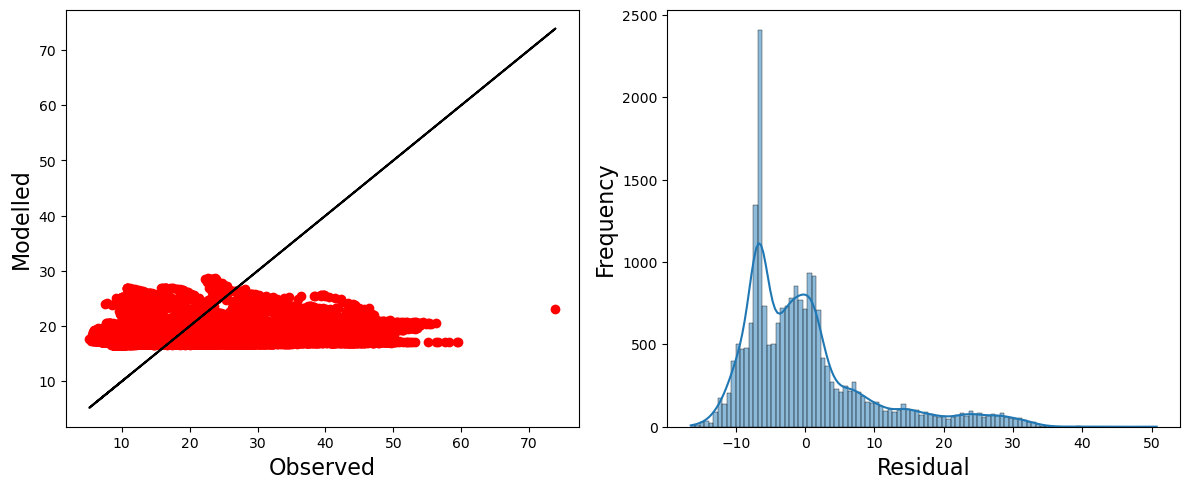

In [91]:
# Regressions

# Best subsets with one combo is the same as 'normal' OLS
res, scalar = nivapy.stats.best_subsets_ols_regression(
    df_hourly[['Q', 'FDOM']].dropna(how='any'),
    'FDOM',
    ['Q'],
    standardise=False,
)

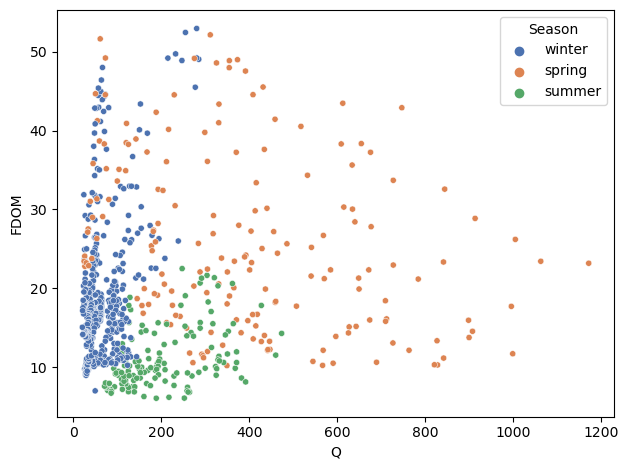

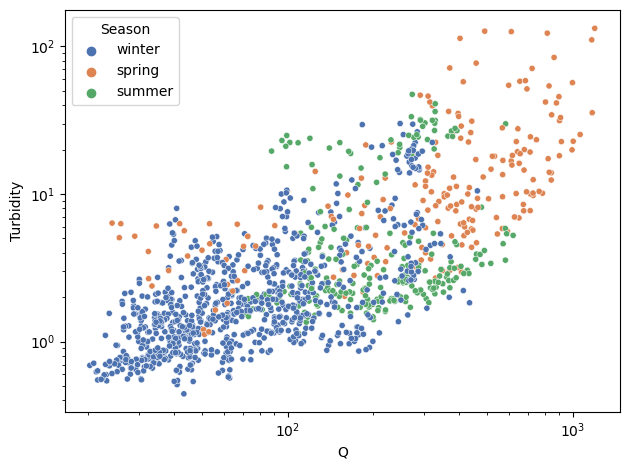

In [92]:
# Daily data

for var in var_li:
    fig = plt.figure()
    sns.scatterplot(x="Q", y=var, data=df, hue="Season", palette="deep",
                    hue_order=hue_order, s=20)
    # if site == "Storelva":

    if var == "Turbidity":
        plt.xscale('log')
        plt.yscale('log')
    plt.tight_layout()
    plt.savefig(r'../figures/FDOM-Q_daily_AllData_%s-%s.png' % (site, var))

In [93]:
# # Different way of doing the same thing
# groups = df_hourly.groupby('Season')

# fig, ax = plt.subplots()
# for name, group in groups:
#     ax.plot(group['Q'], group['FDOM'], marker='o', linestyle='', ms=2, label=name)
# ax.legend()
# # df_hourly.plot(x='Q', y='FDOM', kind='scatter')

# Regressions

## DOC from FDOM

### Basic statsmodels

In [94]:
# Which frequency data join to use?
data_join_freq = 'hourly'  # or hourly

if data_join_freq == 'daily':
    fdom_reg_df = chem_reg_df
    spm_reg_df = spm_reg_df

else:
    fdom_reg_df = fdom_reg_df_hourly
    spm_reg_df = spm_reg_df_hourly

print(fdom_reg_df.head())
print(spm_reg_df.head())

                      FDOM   DOC  Season      Freshet
datetime                                             
2018-02-12 14:00:00  10.06  0.90  winter  Not freshet
2018-03-05 14:00:00   9.57  1.10  winter  Not freshet
2018-04-03 16:00:00   9.08  0.98  winter  Not freshet
2018-05-07 10:00:00  38.68  3.50  spring      Freshet
2018-06-04 00:00:00  11.72  1.00  spring      Freshet
                     Turbidity   SPM      Freshet
datetime                                         
2018-06-04 00:00:00       3.49  5.83      Freshet
2018-07-02 15:00:00       2.33  1.63  Not freshet
2018-08-13 10:00:00       4.89  3.74  Not freshet
2018-09-04 13:00:00       1.16  0.86  Not freshet
2018-10-01 12:00:00       4.31  0.77  Not freshet


In [95]:
def ols_regression(df, formula, plot_var):
    """OLS regression using statsmodels. Prints model summary
    and displays diagnostic plots.

    Args
        df:       Dataframe
        formula:  Str. Patsy-style formula
        plot_var: Str. One of the independent variables to analyse
                  using plots

    Returns
        Statsmodels result object.
    """
    import statsmodels.api as sm
    import statsmodels.formula.api as smf

    mod = smf.ols(formula=formula, data=df)
    res = mod.fit()
    print(res.summary())

    # Diagnostic plots
    fig = sm.graphics.plot_regress_exog(res, plot_var)
    fig.tight_layout(pad=1.0)

In [96]:
# res = ols_regression(fdom_reg_df, 'DOC ~ FDOM', 'FDOM')

In [97]:
# if site == 'Malselva':
#     # Regression grouping by season
#     groups = fdom_reg_df.groupby("Freshet")
#     for season, group_df in groups:
#         print('#############################################################')
#         print(f'# {season}')
#         res = ols_regression(group_df, 'DOC ~ FDOM', 'FDOM')

### With nivapy

Regression results for the model with the lowest AIC:

                            OLS Regression Results                            
Dep. Variable:                    DOC   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     52.54
Date:                Thu, 10 Nov 2022   Prob (F-statistic):           5.64e-09
Time:                        09:58:14   Log-Likelihood:                -49.182
No. Observations:                  45   AIC:                             102.4
Df Residuals:                      43   BIC:                             106.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

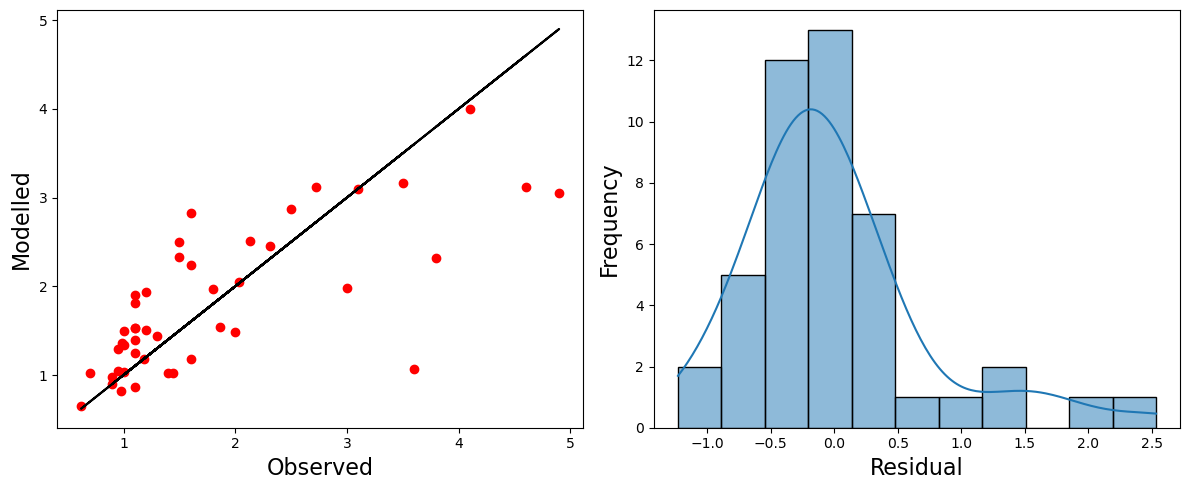

In [98]:
# Best subsets with one combo is the same as 'normal' OLS
doc_res, scalar = nivapy.stats.best_subsets_ols_regression(
    fdom_reg_df.dropna(how='any'),
    'DOC',
    ['FDOM'],
    standardise=False,
)

In [99]:
# Can access coefficients
doc_res.params

const    0.106642
FDOM     0.078972
dtype: float64

#############################################################
# Freshet
Regression results for the model with the lowest AIC:

                            OLS Regression Results                            
Dep. Variable:                    DOC   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     28.36
Date:                Thu, 10 Nov 2022   Prob (F-statistic):           4.62e-05
Time:                        09:58:14   Log-Likelihood:                -21.521
No. Observations:                  20   AIC:                             47.04
Df Residuals:                      18   BIC:                             49.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----

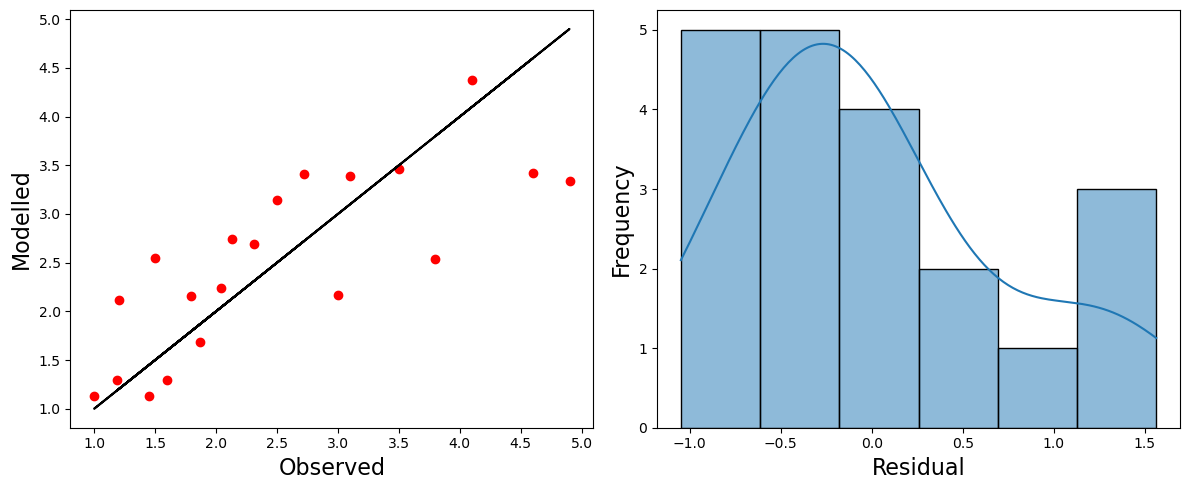

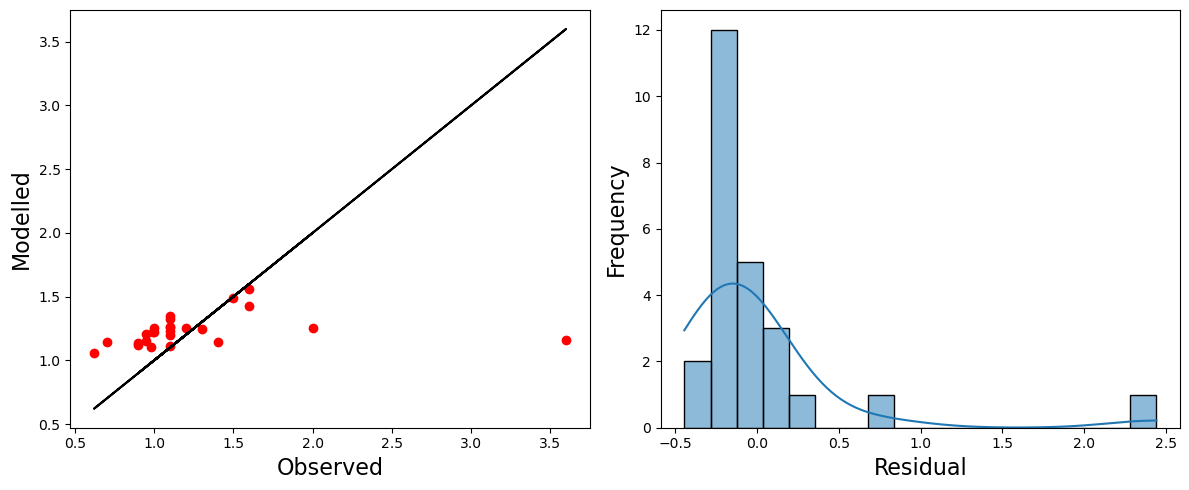

In [100]:
if site == 'Malselva':
    # Regression grouping by season
    groups = fdom_reg_df.groupby("Freshet")
    for season, group_df in groups:
        print('#############################################################')
        print(f'# {season}')
        # Best subsets with one combo is the same as 'normal' OLS
        res, scalar = nivapy.stats.best_subsets_ols_regression(
            group_df, 
            'DOC', 
            ['FDOM'], 
            standardise=False,
        )

For Målselva, get the same regression coefficients using this method as from Excel. Good. But lots more info here and a nice diagnostic plot.

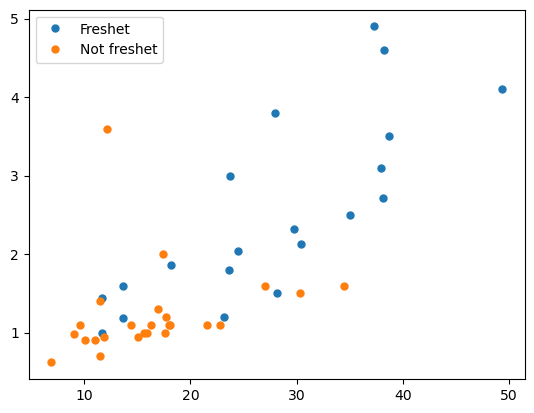

In [101]:
if site == 'Malselva':
    # Regression grouping by season
    groups = fdom_reg_df.groupby("Freshet")
    fig, ax = plt.subplots()
    for season, group in groups:
        ax.plot(group['FDOM'], group['DOC'], marker='o', linestyle='', ms=5, label=season)
    ax.legend()
    # df_hourly.plot(x='Q', y='FDOM', kind='scatter')

### Regressions from excel for Målselva

For FDOM for Målselva, grouped into freshet or not

In [102]:
if site == 'Malselva':
    coeffs_df = pd.read_csv(r'../data/Malselva_FDOM-DOC_coeffs.csv', index_col=0, header=1)
    print(coeffs_df)

              m      c
Freshet               
0        0.0307  0.564
1        0.0646  0.314


## SPM from turbidity

Regression results for the model with the lowest AIC:

                            OLS Regression Results                            
Dep. Variable:                    SPM   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     46.05
Date:                Thu, 10 Nov 2022   Prob (F-statistic):           2.63e-08
Time:                        09:58:16   Log-Likelihood:                -150.22
No. Observations:                  45   AIC:                             304.4
Df Residuals:                      43   BIC:                             308.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

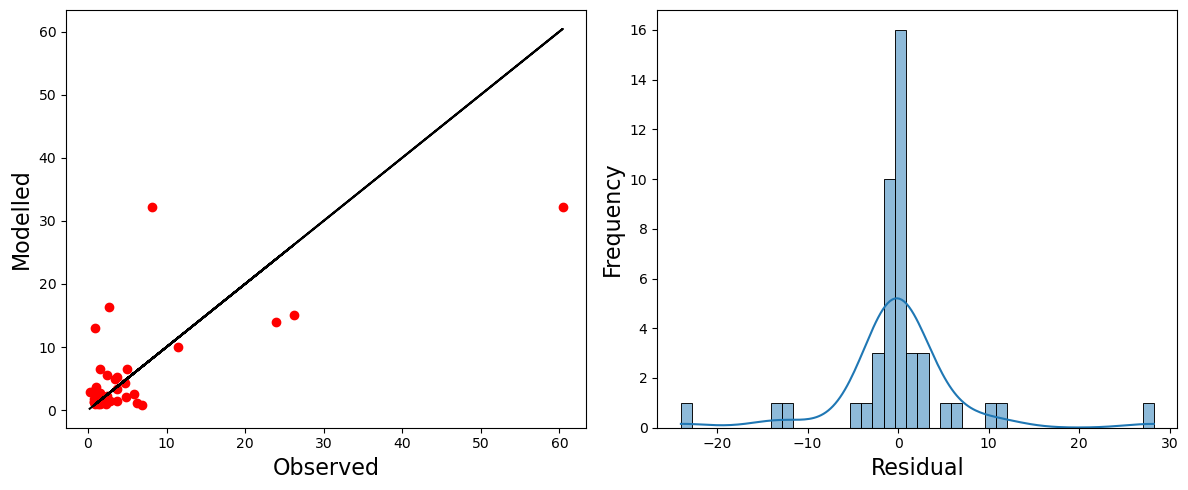

In [103]:
# Best subsets with one combo is the same as 'normal' OLS
spm_res, scalar = nivapy.stats.best_subsets_ols_regression(
    spm_reg_df,
    'SPM',
    ['Turbidity'],
    standardise=False,
)

<AxesSubplot:xlabel='Turbidity'>

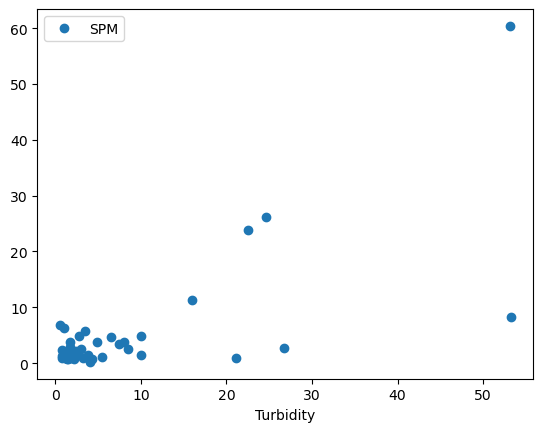

In [104]:
spm_reg_df.plot(x='Turbidity', y='SPM', marker='o', linestyle='')

## DOC and SPM regressions from Maeve

In [105]:
reg_params = pd.read_excel(r'../data/Regression_Coefficients_Maeve.xlsx', index_col=[0, 1])
reg_params.loc['Storelva', 'DOC']

slope        0.0729
intercept    1.0700
R2           0.5200
Name: (Storelva, DOC), dtype: float64

# Fluxes

3 ways of calculating daily fluxes:
1) Linear interpolation of grab samples at monthly frequency
2) Linear interpolation of grab samples using extra high frequency samples
3) Relationships between sensor data and grab samples, for Målselva split by freshet vs not.

## Caluculate daily fluxes

In [106]:
# flux_daily_df = pd.read_csv(r'../data/%s_daily_fluxes.csv' % site, index_col=0,
#                             parse_dates=True)
# flux_daily_df.head()

# for var in ['DOC']:#, 'SPM']:
#     ax = plt.subplot()
#     df = flux_daily_df.loc[flux_daily_df['variable']==var]
#     for method in ['linear', 'logqc', 'sensor', 'qc']:
#         df['concentration_%s' % method].plot(ax=ax)
#         plt.legend()

In [107]:
fluxes_daily_df = df.loc[:, ['Q', 'FDOM', 'Turbidity']]
fluxes_daily_df = fluxes_daily_df.asfreq('D')

# First interpolate grab samples
chem_df.index = pd.to_datetime(chem_df.index, yearfirst=True)

concat_li = []

for var_long in ['DOC_mg_L', 'SPM_mg_L']:
    var = var_long[:3]

    # Interpolate just monthly samples
    if site == 'Malselva':
        interp_monthly = chem_df.loc[chem_df['sampling'] == 'monthly', '%s' % var_long].asfreq('D').interpolate()
    else:
        interp_monthly = chem_df.loc[:, '%s' % var_long].asfreq('D').interpolate()
    interp_monthly.name = '%s_interp_monthly' % var

    # If Målselva, add extra interpolation and remove dodgy 2020 DOC data
    if site == 'Malselva':
        interp_extra = chem_df.loc[:, '%s' % var_long].asfreq('D').interpolate()
        interp_extra.name = '%s_interp_extra' % var

        if var == 'DOC':
            interp_monthly = interp_monthly.loc[:'2020-01-31']
            interp_extra = interp_extra.loc[:'2020-01-31']

        concat_li.append(interp_extra)

    concat_li.append(interp_monthly)

# Estimate DOC from FDOM
if site == 'Malselva':

    # Split by freshet vs not
    fluxes_daily_df['freshet'] = fluxes_daily_df.index.month.map(freshet)
    freshet_conc = fluxes_daily_df.loc[fluxes_daily_df['freshet'] == 'Freshet', 'FDOM'] * coeffs_df.loc[1, 'm'] + coeffs_df.loc[1, 'c']
    notfreshet_conc = fluxes_daily_df.loc[fluxes_daily_df['freshet'] == 'Not freshet', 'FDOM'] * coeffs_df.loc[0, 'm'] + coeffs_df.loc[0, 'c']
    DOC_FDOM = pd.concat([notfreshet_conc, freshet_conc], axis=0).sort_index()
    DOC_FDOM.name = 'DOC_sensor'
    concat_li.append(DOC_FDOM)

else:
    # No split by season
    fluxes_daily_df['DOC_sensor'] = (fluxes_daily_df['FDOM']
                                     * reg_params.loc[site, 'DOC']['slope']
                                     + reg_params.loc[site, 'DOC']['intercept'])

# Estimate SPM from turbidity
fluxes_daily_df['SPM_sensor'] = (fluxes_daily_df['Turbidity']
                                 * reg_params.loc[site, 'SPM']['slope']
                                 + reg_params.loc[site, 'SPM']['intercept'])

concat_li.append(fluxes_daily_df)

# Add to master fluxes df
fluxes_daily_df = pd.concat(concat_li, axis=1)

# Calculate fluxes in tonnes/day
for col in ['DOC_interp_monthly', 'DOC_interp_extra', 'DOC_sensor',
            'SPM_interp_monthly', 'SPM_interp_extra', 'SPM_sensor']:
    if col in fluxes_daily_df.columns:
        fluxes_daily_df['flux_%s' % col] = (fluxes_daily_df[col]
                                            * fluxes_daily_df['Q']
                                            * 86400 * 10**-6)

# Fill in any short NaN periods
print(fluxes_daily_df[['FDOM', 'Turbidity']].isna().sum())
fluxes_daily_df = fluxes_daily_df.interpolate(method='linear', axis=0, limit=10)
print(fluxes_daily_df[['FDOM', 'Turbidity']].isna().sum())

fluxes_daily_df.loc['2019-05-01': '2019-05-08']

FDOM         532
Turbidity    157
dtype: int64
FDOM         512
Turbidity    150
dtype: int64


,DOC_interp_extra,DOC_interp_monthly,SPM_interp_extra,SPM_interp_monthly,DOC_sensor,Q,FDOM,Turbidity,freshet,SPM_sensor,flux_DOC_interp_monthly,flux_DOC_interp_extra,flux_DOC_sensor,flux_SPM_interp_monthly,flux_SPM_interp_extra,flux_SPM_sensor
2019-05-01,1.407692,1.407692,3.984615,3.984615,3.190127,229.272210,44.522083,7.973750,Freshet,3.37507,27.885144,27.885144,63.193597,78.931720,78.931720,66.857163
2019-05-02,1.417949,1.417949,4.087436,4.087436,2.907744,216.492079,40.150833,9.164583,Freshet,3.68945,26.522611,26.522611,54.389103,76.455144,76.455144,69.010851
2019-05-03,1.428205,1.428205,4.190256,4.190256,2.642669,211.698381,36.047500,7.002500,Freshet,3.11866,26.122929,26.122929,48.336363,76.642891,76.642891,57.042599
2019-05-04,1.438462,1.438462,4.293077,4.293077,2.407686,203.710109,32.410000,5.254583,Freshet,2.65721,25.317719,25.317719,42.376606,75.560530,75.560530,46.768367
2019-05-05,1.448718,1.448718,4.395897,4.395897,2.136824,192.529103,28.217083,4.422083,Freshet,2.43743,24.098720,24.098720,35.545023,73.123620,73.123620,40.545465
2019-05-06,1.458974,1.458974,4.498718,4.498718,1.953602,177.302844,25.380833,4.499167,Freshet,2.45778,22.349978,22.349978,29.927159,68.915706,68.915706,37.650648
2019-05-07,1.469231,1.469231,4.601538,4.601538,1.913738,179.093625,24.763750,5.838750,Freshet,2.81143,22.734420,22.734420,29.612591,71.202776,71.202776,43.503194
2019-05-08,1.479487,1.479487,4.704359,4.704359,1.986171,186.597085,25.885000,8.372500,Freshet,3.48034,23.852275,23.852275,32.021025,75.843620,75.843620,56.110000


## Daily flux plots

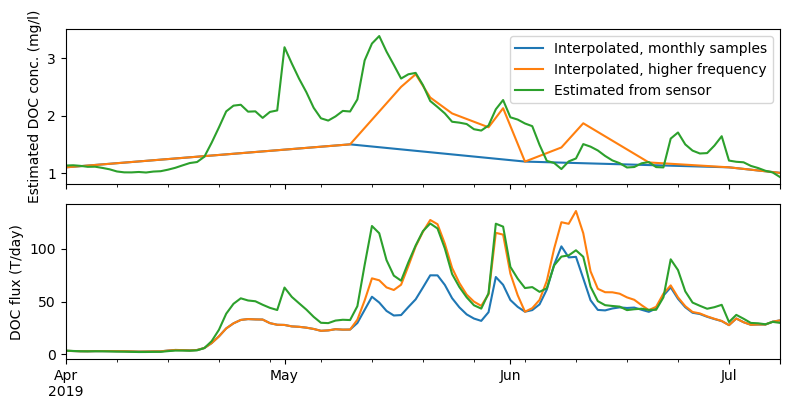

In [108]:
# DOC, 2019
if site == 'Malselva':
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
    fluxes_daily_df.loc['2019-04-01': '2019-07-08',
                        ['DOC_interp_monthly', 'DOC_interp_extra', 'DOC_sensor']].plot(ax=axs[0])
    axs[0].set_ylabel('Estimated DOC conc. (mg/l)')

    axs[0].legend(labels=['Interpolated, monthly samples', 'Interpolated, higher frequency',
                          'Estimated from sensor'])

    fluxes_daily_df.loc['2019-04-01': '2019-07-08',
                        ['flux_DOC_interp_monthly', 'flux_DOC_interp_extra', 'flux_DOC_sensor']].plot(ax=axs[1], legend=False)
    axs[1].set_ylabel('DOC flux (T/day)')

    plt.tight_layout()
    plt.savefig(r'../figures/DOC_daily_fluxes_%s_freshet-2019.png' % site)

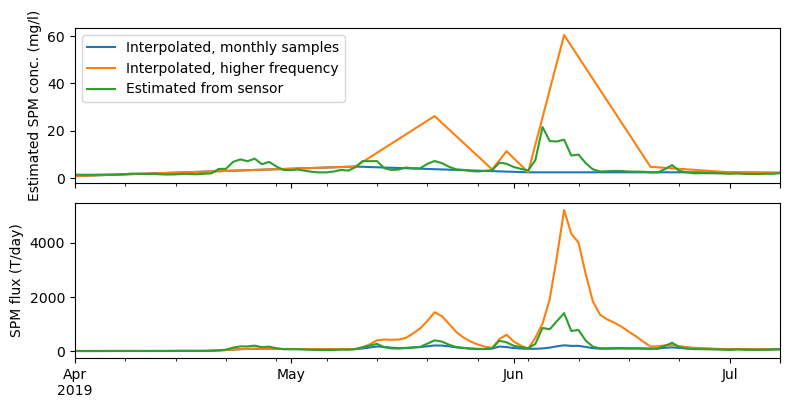

In [109]:
# SPM, 2019, Målselva
if site == 'Malselva':
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
    fluxes_daily_df.loc['2019-04-01': '2019-07-08',
                        ['SPM_interp_monthly', 'SPM_interp_extra', 'SPM_sensor']].plot(ax=axs[0])
    axs[0].set_ylabel('Estimated SPM conc. (mg/l)')

    axs[0].legend(labels=['Interpolated, monthly samples', 'Interpolated, higher frequency',
                          'Estimated from sensor'])

    fluxes_daily_df.loc['2019-04-01': '2019-07-08',
                        ['flux_SPM_interp_monthly', 'flux_SPM_interp_extra', 'flux_SPM_sensor']].plot(ax=axs[1], legend=False)
    axs[1].set_ylabel('SPM flux (T/day)')

    plt.tight_layout()
    plt.savefig(r'../figures/SPM_daily_fluxes_%s_freshet-2019.png' % site)

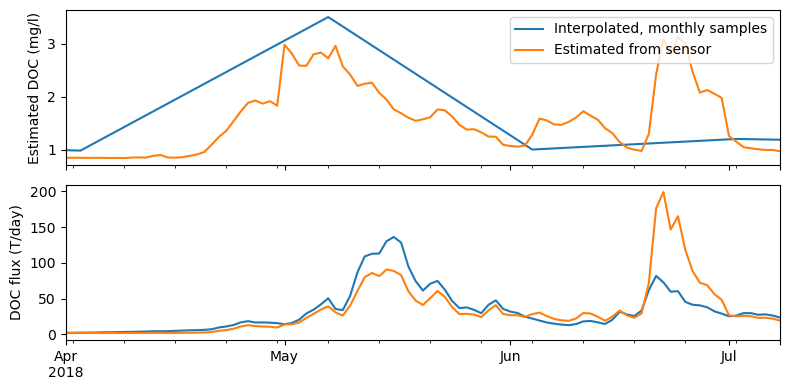

In [110]:
# DOC, 2018, Målselva
if site == 'Malselva':
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
    fluxes_daily_df.loc['2018-04-01': '2018-07-08',
                        ['DOC_interp_monthly', 'DOC_sensor']].plot(ax=axs[0])
    axs[0].set_ylabel('Estimated DOC (mg/l)')

    axs[0].legend(labels=['Interpolated, monthly samples', 'Estimated from sensor'])

    fluxes_daily_df.loc['2018-04-01': '2018-07-08',
                        ['flux_DOC_interp_monthly', 'flux_DOC_sensor']].plot(ax=axs[1], legend=False)
    axs[1].set_ylabel('DOC flux (T/day)')

    plt.tight_layout()
    plt.savefig(r'../figures/DOC_daily_fluxes_%s_freshet-2018.png' % site)

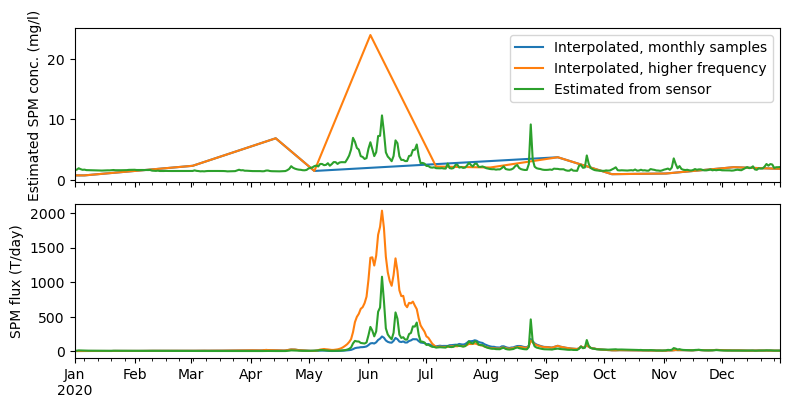

In [123]:
# SPM, 2020, Målselva
if site == 'Malselva':
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
    fluxes_daily_df.loc['2020-01-01': '2020-12-31',
                        ['SPM_interp_monthly', 'SPM_interp_extra', 'SPM_sensor']].plot(ax=axs[0])
    axs[0].set_ylabel('Estimated SPM conc. (mg/l)')

    axs[0].legend(labels=['Interpolated, monthly samples',
                          'Interpolated, higher frequency', 'Estimated from sensor'])

    fluxes_daily_df.loc['2020-01-01': '2020-12-31',
                        ['flux_SPM_interp_monthly', 'flux_SPM_interp_extra', 'flux_SPM_sensor']].plot(ax=axs[1], legend=False)
    axs[1].set_ylabel('SPM flux (T/day)')

    plt.tight_layout()
    plt.savefig(r'../figures/SPM_daily_fluxes_%s_2021.png' % site)

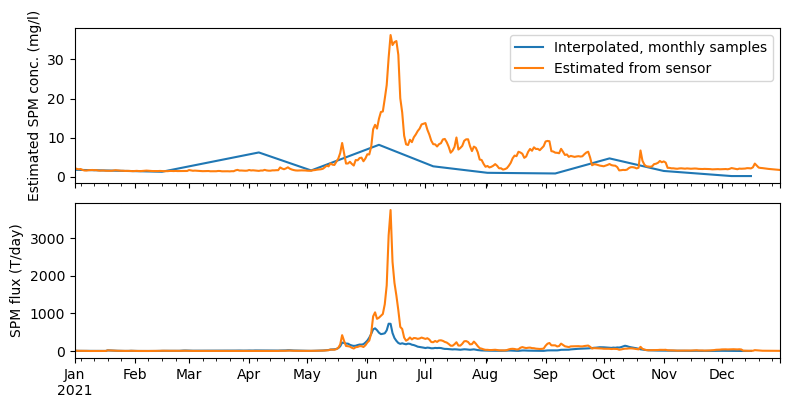

In [120]:
# SPM, 2021, Målselva
if site == 'Malselva':
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
    fluxes_daily_df.loc['2021-01-01': '2021-12-31',
                        ['SPM_interp_monthly', 'SPM_sensor']].plot(ax=axs[0])
    axs[0].set_ylabel('Estimated SPM conc. (mg/l)')

    axs[0].legend(labels=['Interpolated, monthly samples', 'Estimated from sensor'])

    fluxes_daily_df.loc['2021-01-01': '2021-12-31',
                        ['flux_SPM_interp_monthly', 'flux_SPM_sensor']].plot(ax=axs[1], legend=False)
    axs[1].set_ylabel('SPM flux (T/day)')

    plt.tight_layout()
    plt.savefig(r'../figures/SPM_daily_fluxes_%s_2021.png' % site)

In [111]:
# DOC, 2018, Storelva
if site == 'Storelva':
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
    fluxes_daily_df.loc['2018-01-01': '2018-12-31',
                        ['DOC_interp_monthly', 'DOC_sensor']].plot(ax=axs[0])
    axs[0].set_ylabel('Estimated DOC (mg/l)')

    axs[0].legend(labels=['Interpolated, monthly samples', 'Estimated from sensor'])

    fluxes_daily_df.loc['2018-01-01': '2018-12-31',
                        ['flux_DOC_interp_monthly', 'flux_DOC_sensor']].plot(ax=axs[1], legend=False)
    axs[1].set_ylabel('DOC flux (T/day)')

    plt.tight_layout()
    plt.savefig(r'../figures/DOC_daily_fluxes_%s_2018.png' % site)

In [112]:
# SPM
if site == 'Storelva':
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
    fluxes_daily_df.loc['2018-01-01': '2018-12-31',
                        ['SPM_interp_monthly', 'SPM_sensor']].plot(ax=axs[0])
    axs[0].set_ylabel('Estimated SPM conc. (mg/l)')

    axs[0].legend(labels=['Interpolated, monthly samples',
                          'Sensor-based'])

    fluxes_daily_df.loc['2018-01-01': '2018-12-31',
                        ['flux_SPM_interp_monthly', 'flux_SPM_sensor']].plot(ax=axs[1], legend=False)
    axs[1].set_ylabel('SPM flux (T/day)')

    plt.tight_layout()
    plt.savefig(r'../figures/SPM_daily_fluxes_%s_2018.png' % site)

In [113]:
# SPM, Storelva, 2021
if site == 'Storelva':
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
    fluxes_daily_df.loc['2021-01-01': '2021-12-31',
                        ['SPM_interp_monthly', 'SPM_sensor']].plot(ax=axs[0])
    axs[0].set_ylabel('Estimated SPM conc. (mg/l)')

    axs[0].legend(labels=['Interpolated, monthly samples',
                          'Sensor-based'])

    fluxes_daily_df.loc['2021-01-01': '2021-12-31',
                        ['flux_SPM_interp_monthly', 'flux_SPM_sensor']].plot(ax=axs[1], legend=False)
    axs[1].set_ylabel('SPM flux (T/day)')

    plt.tight_layout()
    plt.savefig(r'../figures/SPM_daily_fluxes_%s_2021.png' % site)

## Monthly flux plots

In [114]:
# fluxes_monthly_df['date'] = fluxes_monthly_df.index
# new_index = fluxes_monthly_df['date'].apply(lambda x: x.strftime('%Y-%m'))
# # new_index = pd.to_datetime(new_index)
# fluxes_monthly_df.set_index(new_index, inplace=True)

# # index = pd.to_datetime(df.index, yearfirst=True)
# # df.index = index

# fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 5))

# for i, var in enumerate(['DOC', 'SPM']):
#     if var == 'DOC':
#         legend=True
#     else:
#         legend=False
#     fluxes_monthly_df[['flux_%s_interp_monthly' % var,
#                        'flux_%s_interp_extra' % var,
#                        'flux_%s_sensor' % var]].plot(kind='bar',
#                                                      figsize=(10, 5),
#                                                      ax=axs[i], legend=legend)
#     axs[i].set_ylabel('%s load (T/month)' % var)
#     axs[i].set_xlabel('')

# axs[0].legend(labels=['Interpolated, monthly samples', 'Interpolated, higher frequency',
#                       'Estimated from sensor'])
#     # #set ticks every week
#     # axs[i].xaxis.set_major_locator(mdates.MonthLocator())
#     # #set major ticks format
#     # axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))

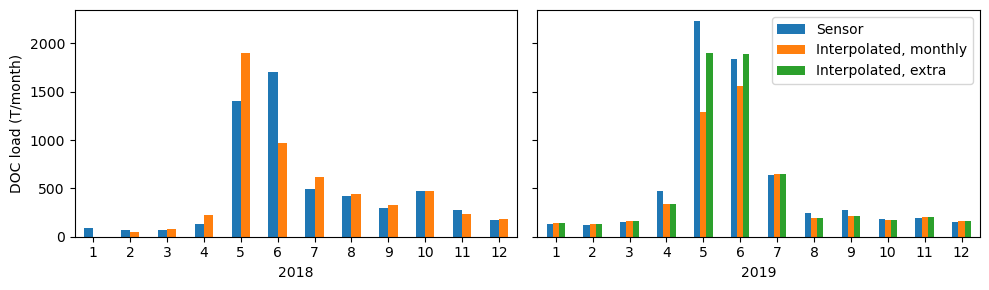

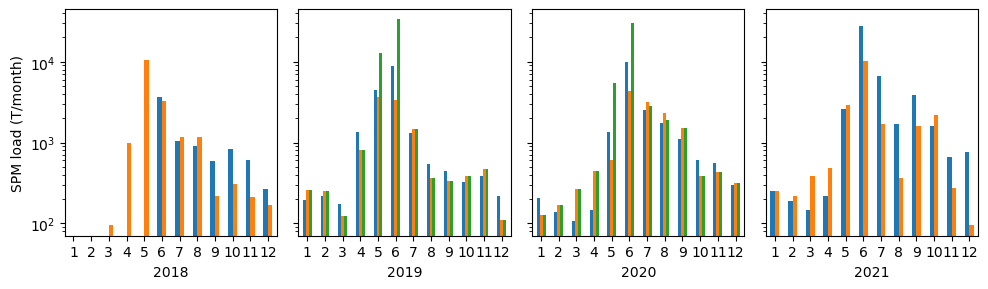

In [115]:
if site == 'Malselva':
    col_li = ['flux_DOC_interp_monthly', 'flux_DOC_interp_extra',
              'flux_DOC_sensor', 'flux_SPM_interp_monthly',
              'flux_SPM_interp_extra', 'flux_SPM_sensor']
else:
    col_li = ['flux_DOC_interp_monthly', 'flux_DOC_sensor',
              'flux_SPM_interp_monthly', 'flux_SPM_sensor']

fluxes_monthly_df = fluxes_daily_df.loc[:, col_li].resample('M').sum()

index = pd.to_datetime(fluxes_monthly_df.index)
fluxes_monthly_df.index = index

# Write to csv
fluxes_monthly_df.to_csv(r'../data/fluxes_monthly_%s.csv' % site)

# Plot
yr_li_dict = {'Malselva': {'DOC': [2018, 2019],
                           'SPM': [2018, 2019, 2020, 2021]},
              'Storelva': {'DOC': [2018, 2019, 2020, 2021],
                           'SPM': [2018, 2019, 2020, 2021]}}

for var in ['DOC', 'SPM']:
    yr_li = yr_li_dict[site][var]
    fig, axs = plt.subplots(1, len(yr_li), sharey=True, figsize=(10, 3))
    for i, yr in enumerate(yr_li):
        if yr == 2019 and site == 'Malselva':
            yr_df = fluxes_monthly_df.loc[fluxes_monthly_df.index.year == yr,
                                          ['flux_%s_sensor' % var,
                                           'flux_%s_interp_monthly' % var,
                                           'flux_%s_interp_extra' % var]]

        elif yr == 2020 and site == 'Malselva' and var == 'SPM':
            yr_df = fluxes_monthly_df.loc[fluxes_monthly_df.index.year == yr,
                                          ['flux_%s_sensor' % var,
                                           'flux_%s_interp_monthly' % var,
                                           'flux_%s_interp_extra' % var]]

        else:
            yr_df = fluxes_monthly_df.loc[fluxes_monthly_df.index.year == yr,
                                          ['flux_%s_sensor' % var,
                                           'flux_%s_interp_monthly' % var]]
        yr_df.index = yr_df.index.month
        yr_df.plot(kind='bar', ax=axs[i], legend=False)
        axs[i].set_ylabel('%s load (T/month)' % var)
        axs[i].set_xlabel(yr)
        axs[i].tick_params(axis='x', labelrotation=0)

    if var == 'DOC':
        if site == 'Malselva':
            axs[-1].legend(labels=['Sensor', 'Interpolated, monthly',
                           'Interpolated, extra'])
        else:
            axs[-1].legend(labels=['Sensor', 'Interpolated, monthly'],
                          prop={'size': 8})

    if var == 'SPM':
        axs[i].set_yscale("log")
    plt.tight_layout()
    plt.savefig(r'../figures/monthly_fluxes_%s_%s.png' % (site, var))

## Annual fluxes

In [116]:
# Read in annual fluxes calculated using Ospar method
fluxes_ospar_df = pd.read_excel(r'../data/Ospar_Fluxes_bothstations.xlsx')
fluxes_ospar_df.columns = ['site', 'year', 'ospar_DOC_extra', 'ospar_DOC_monthly', 'ospar_SPM_extra', 'ospar_SPM_monthly']
fluxes_ospar_df = fluxes_ospar_df.loc[fluxes_ospar_df['site'] == site]
fluxes_ospar_df.set_index('year', inplace=True)
fluxes_ospar_df.drop('site', axis=1, inplace=True)

# Convert units to 10^3 Tonnes/yr
fluxes_ospar_df = fluxes_ospar_df/10**6

if site == 'Malselva':
    # Drop values that are the same
    fluxes_ospar_df.loc[[2018, 2021], 'ospar_SPM_extra'] = np.NaN
    fluxes_ospar_df.loc[[2018, 2020, 2021], 'ospar_DOC_extra'] = np.NaN
    # Drop dodgy 2020-2021 DOC data
    fluxes_ospar_df.loc[[2020, 2021], 'ospar_DOC_monthly'] = np.NaN

fluxes_ospar_df

,ospar_DOC_extra,ospar_DOC_monthly,ospar_SPM_extra,ospar_SPM_monthly
year,,,,
2018,NaN,5.63,NaN,18.0
2019,6.33,5.17,67.9,11.9
2020,NaN,NaN,18.0,18.0
2021,NaN,NaN,NaN,21.0


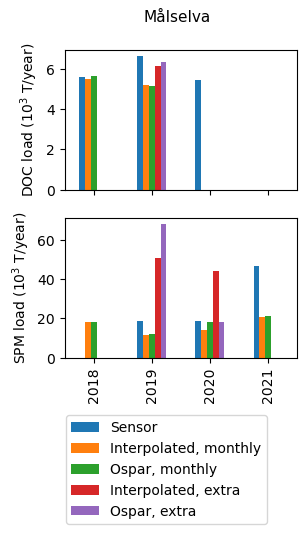

In [118]:
fluxes_yr_df = fluxes_daily_df.loc[:, col_li].resample('Y').sum()
# Convert to kilotonnes (10^3 tonnes/year)
fluxes_yr_df = fluxes_yr_df/10**3

fluxes_yr_df.index = fluxes_yr_df.index.year

# Add Ospar estimates
fluxes_yr_df = pd.concat([fluxes_yr_df, fluxes_ospar_df], axis=1)

# Remove estimates based on grab samples for 2020 and 2021 (almost no data)
if site == 'Malselva':
    fluxes_yr_df.loc[[2020, 2021], ['flux_DOC_interp_monthly', 'flux_DOC_interp_extra']] = np.NaN
    fluxes_yr_df.loc[[2021], ['flux_DOC_sensor']] = np.NaN
    # Also remove 'interpolated_extra' fluxes for 2018 and 2020 for Målselva
    fluxes_yr_df.loc[[2018, 2021], ['flux_DOC_interp_extra', 'flux_SPM_interp_extra']] = np.NaN
    # Turbidity was only measured from mid-2018, so drop
    fluxes_yr_df.loc[2018, 'flux_SPM_sensor'] = np.NaN

if site == 'Storelva':
    fluxes_yr_df.loc[2022, :] = np.NaN

fluxes_yr_df.dropna(how='all', inplace=True)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(3, 4))

for i, var in enumerate(['DOC', 'SPM']):
    if site == 'Malselva':
        var_li = ['flux_%s_sensor' % var,
                  'flux_%s_interp_monthly' % var,
                  'ospar_%s_monthly' % var,
                  'flux_%s_interp_extra' % var,
                  'ospar_%s_extra' % var]
    else:
        var_li = ['flux_%s_sensor' % var,
                  'flux_%s_interp_monthly' % var,
                  'ospar_%s_monthly' % var]

    fluxes_yr_df[var_li].plot(kind='bar',
                              ax=axs[i], legend=False)

    axs[i].set_ylabel('%s load (10$^3$ T/year)' % var)
    axs[i].set_xlabel('')

# plt.tight_layout()

if site == 'Malselva':
    legend = axs[1].legend(labels=['Sensor',
                                   'Interpolated, monthly',
                                   'Ospar, monthly',
                                   'Interpolated, extra',
                                   'Ospar, extra'],
                 loc='right', bbox_to_anchor=(0.9, -0.8),
                 fancybox=True)
else:
    legend = axs[1].legend(labels=['Sensor',
                                   'Interpolated, monthly',
                                   'Ospar'],
             loc='right', bbox_to_anchor=(0.9, -0.8),
             fancybox=True)
plt.suptitle("%s" % site_name_dict[site], size=11);

plt.savefig(r'../figures/fluxes_annual_%s.png' % site, bbox_extra_artists=(legend,), bbox_inches='tight')

In [56]:
fluxes_yr_df.to_csv(r'../data/fluxes_annual_%s.csv' % site)

In [64]:
fluxes_yr_df

,flux_DOC_interp_monthly,flux_DOC_sensor,flux_SPM_interp_monthly,flux_SPM_sensor,ospar_DOC_extra,ospar_DOC_monthly,ospar_SPM_extra,ospar_SPM_monthly
2017,2.929920,2.443738,1.610075,1.357542,3.347824,3.347824,2.621344,2.621344
2018,1.876643,1.939768,0.642532,0.765368,1.950534,1.950534,0.750589,0.750589
2019,3.353662,3.336565,0.858544,1.163568,3.367567,3.367567,0.865615,0.865615
2020,3.166588,3.080009,1.383478,1.338949,3.306823,3.306823,1.747876,1.747876
2021,1.793216,1.973817,0.974677,0.792380,2.026043,2.026043,1.357452,1.357452


# To do

* Boxplots grouped by season, plus for grab samples to compare
* Split into different periods: baseflow, snow melt, summer/autumn flow events